# Datapreperation (From CSV to SQLite) 

This Script converts raw E4 csv data into SQLite files.

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from datetime import datetime, timedelta
from scipy.signal import butter
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from glob import glob
import warnings
import os
from pathlib import Path
warnings.filterwarnings("ignore")

In [95]:
new_eda = pd.read_csv("../2019_Stress_Test/test/data/sensor_data/0625_4_living_eda.csv")
new_temp = pd.read_csv("../2019_Stress_Test/test/data/sensor_data/0625_4_living_temp.csv")

In [78]:
new_temp.to_csv("0625_4_living_temp.csv", index=False)
new_eda.to_csv("0625_4_living_eda.csv", index=False)

In [22]:
def import_and_merge(pathToFolder, local_date):
    
    my_path = Path(pathToFolder)
    if my_path.is_dir():
        filenames = glob(pathToFolder + "/*.csv")
        if len(filenames) != 0:
            filenamePath = filenames[0].split("\\")
            filenameList = filenamePath[1].split("_")[:3]
            filename = ""
            for part in filenameList:
                filename += "_" + part 
        
            listOfdataframes = [pd.read_csv(file) for file in filenames]
            listOfdataframes[0].time = pd.to_datetime(local_date + " "+ listOfdataframes[0].time)
            listOfdataframes[1].time = pd.to_datetime(local_date + " "+ listOfdataframes[1].time)
            listoftimes = [pd.date_range(min(i.time),max(i.time), freq="250ms") for i in listOfdataframes]
            listOfdataframes[0].time = listoftimes[0]
            listOfdataframes[1].time = listoftimes[1]

            files = pd.merge(listOfdataframes[0], listOfdataframes[1])
            files.columns = ["time_iso", "GSR", "ST"]
            files["time_iso"] = pd.to_datetime(files["time_iso"])
            
            files["time_millis"] = pd.to_numeric(files.time_iso)
            return files, filename#pd.concat(listOfdataframes, axis=1).reset_index(drop=True)
        else:
            raise Exception("No csv files were found in the {} folder. Specify a folder that contains files with the extension *.csv".format(pathToFolder))
    else:
        raise Exception("Folder {} doesn't exist. Specify a correct path".format(pathToFolder))

In [33]:
##import_and_merge("../2019_Stress_Test/test\data\sensor_data/", "6/26/2021")

In [3]:
def import_location_data_csv(pathToFolder):
    my_path = Path(pathToFolder)
    if my_path.is_dir():
        filenames = glob(pathToFolder + "/*.csv")
        if len(filenames) != 0:
            listOfdataframes = [pd.read_csv(file) for file in filenames]
            return listOfdataframes[0]#pd.concat(listOfdataframes, axis=1).reset_index(drop=True)
        else:
            raise Exception("No csv files were found in the {} folder. Specify a folder that contains files with the extension *.csv".format(pathToFolder))
    else:
        raise Exception("Folder {} doesn't exist. Specify a correct path".format(pathToFolder))

In [9]:
#import_location_data_csv("../2019_Stress_Test/test/data/location_data/")

,INDEX,RCR,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,VALID,LATITUDE,N/S,LONGITUDE,E/W,HEIGHT,SPEED,Distance
0,535,T,6/26/2021,16:04:58,6/26/2021,18:04:58,0,DGPS,55.684581,N,12.569815,E,94,4.684,9.16
1,536,T,6/26/2021,16:05:03,6/26/2021,18:05:03,0,DGPS,55.684544,N,12.569875,E,93,2.178,5.57
2,537,T,6/26/2021,16:05:08,6/26/2021,18:05:08,0,DGPS,55.684491,N,12.569955,E,92,5.304,7.71
3,538,T,6/26/2021,16:05:13,6/26/2021,18:05:13,0,DGPS,55.684460,N,12.570068,E,92,2.925,7.89
4,539,T,6/26/2021,16:05:18,6/26/2021,18:05:18,0,DGPS,55.684412,N,12.570144,E,91,3.879,7.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,755,T,6/26/2021,16:23:18,6/26/2021,18:23:18,0,Estimated (dead reckoning),55.682915,N,12.571045,E,55,1.844,2.56
221,756,T,6/26/2021,16:24:43,6/26/2021,18:24:43,0,DGPS,55.683663,N,12.571312,E,58,2.780,84.86
222,757,T,6/26/2021,16:24:48,6/26/2021,18:24:48,0,DGPS,55.683602,N,12.571340,E,50,1.177,6.95
223,758,T,6/26/2021,16:24:53,6/26/2021,18:24:53,0,DGPS,55.683602,N,12.571203,E,48,2.875,8.56


In [4]:
def check_sampling_rate(files):
    files["time_iso"] = pd.to_datetime(files["time_iso"])
    sample = files.set_index(files["time_iso"])
    check_sampling = sample.resample("0.250S").asfreq()
    if check_sampling["GSR"].isna().sum() == 0 or check_sampling["ST"].isna().sum() == 0:
        df = check_sampling.reset_index(drop= True)
        return df
    else:
        raise Exception("Missing values")
    

In [28]:
def make_table_sensordata(data):
    
    ST = pd.DataFrame()
    ST["time_millis"] = data.time_millis
    ST["time_iso"] = data.time_iso.dt.strftime("%Y-%m-%dT%H:%M:%S.%f")
    #ST["time_iso"] = data.time_iso
    ST["platform_id"] = 3
    ST["sensor_id"] = 3
    ST["value_real"] = data.ST
    
    GSR = pd.DataFrame()
    GSR["time_millis"] = data.time_millis
    GSR["time_iso"] = data.time_iso.dt.strftime("%Y-%m-%dT%H:%M:%S.%f")
    GSR["platform_id"] = 3
    GSR["sensor_id"] = 7
    GSR["value_real"] = data.GSR
    
    sensordata = pd.concat([ST, GSR], axis = 0)
    sensordata["id"] = np.arange(1, len(sensordata)+1)
    sensordata["value_text"] = np.nan
    sensordata["value_integer"] = np.nan
    sensordata["value_boolean"] = np.nan
    sensordata = sensordata[["id", "time_millis", "time_iso", "platform_id", "sensor_id", "value_text", "value_integer", "value_real", "value_boolean"]]
    sensordata.time_iso = sensordata.time_iso.str[:-3]
    
    sensordata.time_millis = sensordata.time_millis.apply(str).str[:-6].astype("int64")
    
    return sensordata

In [29]:
def linear_interpolate_location(location_data):
    
    location_data["time_iso"] = pd.to_datetime((location_data["LOCAL DATE"] + " "+ location_data["LOCAL TIME"]))
    location_data.set_index("time_iso", inplace = True)
    
    location = location_data.resample("1S").asfreq()
    interpolated = location.interpolate("linear")
    interpolated.reset_index(inplace=True)
    
    interpolated["INDEX"] = np.arange(1, len(interpolated)+1)
    
    return interpolated, location_data["LOCAL DATE"][0]

In [30]:
def make_table_locationdata(data):
    
    data, local_date = linear_interpolate_location(data)
    location = pd.DataFrame()
    location["id"] = data.INDEX
    location["time_millis"] = np.nan
    location["time_iso"] = data.time_iso.dt.strftime("%Y-%m-%dT%H:%M:%S.%f")
    location["latitude"] = data.LATITUDE
    location["longitude"] = data.LONGITUDE
    
    location["provider"] = np.nan
    location["horizontal_accuracy"] = np.nan
    location["altitude"] = data.HEIGHT
    location["vertical_accuracy"] = np.nan
    location["bearing"] = np.nan
    location["bearing_accuracy"] = np.nan
    location["speed"] = data.SPEED
    location["speed_accuracy"] = np.nan
    
    
    location.time_iso = location.time_iso.str[:-3]
    
    location["time_millis"] = (pd.to_numeric(pd.to_datetime(location.time_iso))/10**6).astype("int64")
    return location, local_date

In [32]:
data, _ = import_and_merge("../2019_Stress_Test/test/data/sensor_data/", "6/26/2021")
make_table_sensordata(data)

,id,time_millis,time_iso,platform_id,sensor_id,value_text,value_integer,value_real,value_boolean
0,1,1624730700000,2021-06-26T18:05:00.000,3,3,NaN,NaN,27.010000,NaN
1,2,1624730700250,2021-06-26T18:05:00.250,3,3,NaN,NaN,27.050000,NaN
2,3,1624730700500,2021-06-26T18:05:00.500,3,3,NaN,NaN,27.050000,NaN
3,4,1624730700750,2021-06-26T18:05:00.750,3,3,NaN,NaN,27.050000,NaN
4,5,1624730701000,2021-06-26T18:05:01.000,3,3,NaN,NaN,27.050000,NaN
...,...,...,...,...,...,...,...,...,...
4512,9030,1624731828000,2021-06-26T18:23:48.000,3,7,NaN,NaN,1.218808,NaN
4513,9031,1624731828250,2021-06-26T18:23:48.250,3,7,NaN,NaN,1.222652,NaN
4514,9032,1624731828500,2021-06-26T18:23:48.500,3,7,NaN,NaN,1.218808,NaN
4515,9033,1624731828750,2021-06-26T18:23:48.750,3,7,NaN,NaN,1.218808,NaN


In [34]:
#make_table_locationdata(import_location_data_csv("../2019_Stress_Test/test/data/location_data/"))

In [35]:
##path_to_data = "../2019_Stress_Test/test/data"
##import_and_merge(path_to_data+ "/sensor_data")

In [152]:
def export_to_sqlite(path_to_data = "./test/*"):
    '''Writes the pandas dataframe into a sqlite file from path sensor csv and from path location csv'''
    
    location, local_date = make_table_locationdata(import_location_data_csv(path_to_data+ "/location_data"))
    
    
    data, filename = import_and_merge(path_to_data + "/sensor_data", local_date)
    constrain_sensor = {"id": "INTEGER PRIMARY KEY AUTOINCREMENT"}
    database = "{}/rawData{}.sqlite".format(path_to_data,filename)
    conn = sqlite3.connect(database)
    
    location.to_sql(name='location', con=conn, index=False, dtype=constrain_sensor)
    make_table_sensordata(data).to_sql(name='sensordata', con=conn, index=False, dtype=constrain_sensor)
    

    
    conn.close()

In [162]:
filename = glob("./test/*")
for i in filename
    export_to_sqlite(path_to_data = i)

../2019_Stress_Test/test\data\
../2019_Stress_Test/test\data2\


## Data preparation in Python

In [12]:
def resampling(dataframe, interpolationMethod = "linear"):
    selecteddata = dataframe.set_index('time_iso')
    
    upsampled = selecteddata.resample("1S").mean()
    interpolated = upsampled.interpolate(method = interpolationMethod, order = 2)
    export_dataframe = interpolated.reset_index()
    return export_dataframe

In [13]:
def filter_data(order, cutoff_low, cutoff_high, data, column):
    
    b, a = butter(order, cutoff_low, 'low', analog=False)  
    c, d = butter(order, cutoff_high, "high", analog=False)
    
    apply_lowpass = sp.signal.lfilter(b, a, data[column])
    filteredGSR = sp.signal.lfilter(c, d, apply_lowpass)
    
    return filteredGSR

In [426]:
#resampling(check_sampling_rate(test[0], "value_real"), "GSR")
def datapreprocessing(path = "../2019_Stress_Test/test/"):
    import_df = import_and_merge(path)
    merged_df = check_sampling_rate(import_df)
    filteredGSR = filter_data(1, 0.5, 0.05, merged_df, "GSR")
    filteredST = filter_data(2, 0.1, 0.01, merged_df, "ST")
    merged_df["GSR"] = filteredGSR
    merged_df["ST"] = filteredST
    final_df = resampling(merged_df)
    final_df["time_millis"] = (pd.to_numeric(pd.to_datetime(final_df.time_iso))/10**9).astype("int64")
    final_df = final_df[["time_millis", "time_iso", "GSR", "ST"]]
    return final_df

pre_df = datapreprocessing("../2019_Stress_Test/test/data")#.to_csv("../2019_Stress_Test/test/data/preprocessed/preprocessed.csv", index=False)

In [427]:
pre_df.drop(["time_iso"], axis=1, inplace =True)

In [428]:
pre_df.columns= ["TimeNum", "GSRfiltered", "STfiltered"]

In [429]:
r_pre = pd.read_csv("test.csv").drop(["Unnamed: 0"], axis=1)

In [449]:
r_pre.GSRfiltered = r_pre.GSRfiltered.astype("float64")
pre_df.GSRfiltered = pre_df.GSRfiltered.astype("float64")

In [ ]:
print(os.path.isdir(rootdir))
sqlites = glob.glob(rootdir + "/*.sqlite")
if len(sqlites) < 1:
    raise Exception("Error: No SQLites found in {}".format(rootdir))
for sqlite in sqlites:
    sqlite = os.path.abspath(sqlite)
    command = 'Rscript --vanilla ~/host_data/humansensorik_module_quickanalysis/detect_mos.R {}'.format(sqlite)
    ##Potentially use the command below in the future for predefined arguments
    ##command = 'Rscript --vanilla ~/host_data/humansensorik_module_quickanalysis/detect_mos.R {} {} {}'.format(sqlite,mosdetection_latency,mosdetection_mospercentage)
    try:
        p = subprocess.check_output([command],shell=True,stdin=subprocess.PIPE,stderr=subprocess.PIPE)
        print(p)
    except subprocess.CalledProcessError as e:
        print(e)
        print(e.output)

In [24]:
## Plot ST, GSR
def plotSTGSR(data):
    
    fig,ax1=plt.subplots(figsize=(12,8))
    
    ax2 = ax1.twinx()
    ax1.plot(data.time_iso, data.GSR)
    ax1.set_xlabel("time_iso")
    ax1.set_ylabel("GSR")
    ax1.set_ylim(min(data.GSR) *1, max(data.GSR) *1)
    ax2.plot(data.time_iso, data.ST, color = "green")
    ax2.set_ylabel("ST")
    for i in data.index:
        if data.mos[i] == 1:
            plt.axvline(data.time_iso[i], color = "grey", linestyle = 'dotted')
    plt.show()
    

## Visualize MOS

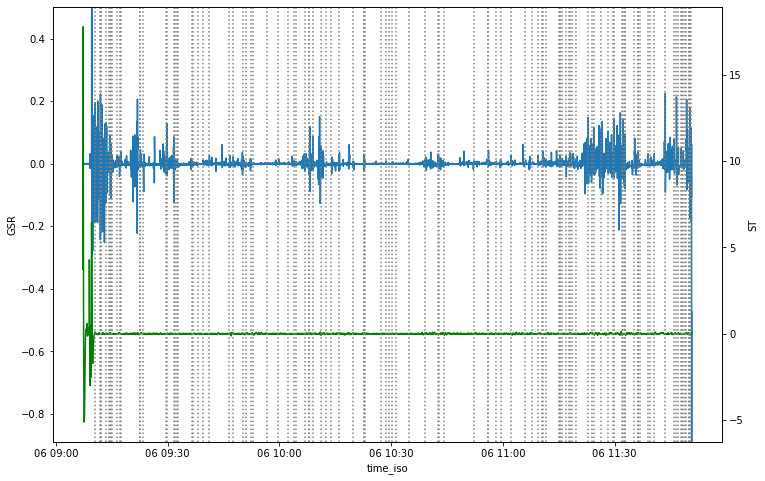

In [237]:
mos_data = pd.read_csv("../2019_Stress_Test/test/data/preprocessed/mos_rule_based_erg.csv")
stress_index = mos_data[["Unnamed: 0"]]
mos_idx = mos_data["Unnamed: 0"].to_list()
pre_df["mos"] = 0
pre_df.loc[mos_idx, "mos"] = 1
plotSTGSR(pre_df)